# NetFlix Prediction

# Business Problem:

  Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.  

  Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.  
  
  Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

# Business Objectives and constraints

Objectives:
1. Predict the rating that a user would give to a movie that he ahs not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)


Constraints:
1. Some form of interpretability.

# Data

Data files :   
combined_data_1.txt
combined_data_2.txt 
combined_data_3.txt
combined_data_4.txt 
movie_titles.csv 

The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:CustomerID,Rating,Date

MovieIDs range from 1 to 17770 sequentially.  
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.  
Ratings are on a five star (integral) scale from 1 to 5.  
Dates have the format YYYY-MM-DD.

# Machine Learning Problem:

For a given movie and user we need to predict the rating would be given by him/her to the movie.   
The given problem is a Recommendation problem   
It can also seen as a Regression problem  

# Performance Metric:

Mean Absolute Percentage Error  
Root Mean Squared Error

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Load Data

In [2]:
path = r'C:\Users\Friend\AI\AI_datasets\NetFlix Recommendations'
data = os.path.join(path,'data.csv')
txt1 = os.path.join(path,'combined_data_1.txt')
txt2 = os.path.join(path,'combined_data_2.txt')
txt3 = os.path.join(path,'combined_data_3.txt')
txt4 = os.path.join(path,'combined_data_4.txt')

In [ ]:
if not os.path.isfile(data):
    data = open(data, mode='w')
    row = list()
    files=[txt1,txt2,txt3,txt4]
    for file in files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()                        

In [5]:
df = pd.read_csv(data, sep=',',names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
df.sort_values(by='date', inplace=True)
df.shape

(100480507, 4)

In [6]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [7]:
#Checking for null values
sum(df.isnull().any())

0

In [8]:
#checking for duplicates
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool)
dups

0

In [10]:
print('No of movies:',len(np.unique(df.movie)))
print('No of users:',len(np.unique(df.user)))
print('no of ratings:',df.shape[0])

No of movies: 17770
No of users: 480189
no of ratings: 100480507


In [11]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

# Split Data

In [13]:
train_path = os.path.join(path,'train.csv')
test_path = os.path.join(path,'test.csv')

In [15]:
#Split whole data into 80:20 ratio

train_df = df.iloc[:int(df.shape[0]*0.80)]
test_df = df.iloc[int(df.shape[0]*0.80):]

if not os.path.isfile(train_path):
    train_df.to_csv(train_path,index = False)
    
if not os.path.isfile(test_path):
    test_df.to_csv(test_path,index = False)

In [17]:
train_df = pd.read_csv(train_path, parse_dates=['date'])
test_df = pd.read_csv(test_path)
print(train_df.shape,test_df.shape)

(80384405, 4) (20096102, 4)


In [18]:
#Basic Statistics on train and test data

print('No of movies in train data:',len(np.unique(train_df.movie)))
print('No of users in train data:',len(np.unique(train_df.user)))
print('no of ratings in train data:',train_df.shape[0])


print('No of movies in test data:',len(np.unique(test_df.movie)))
print('No of users in test data:',len(np.unique(test_df.user)))
print('no of ratings in test data:',test_df.shape[0])

No of movies in train data: 17424
No of users in train data: 405041
no of ratings in train data: 80384405
No of movies in test data: 17757
No of users in test data: 349312
no of ratings in test data: 20096102


# Exploratory Data Analysis:

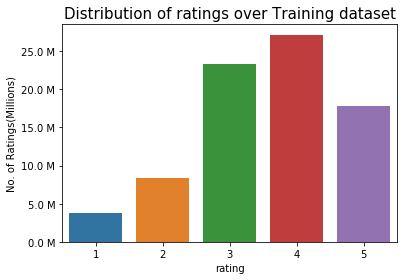

In [19]:
# Distribution of ratings

def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"


fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

In [20]:
# Adding extra column(weekday) to data

train_df['day_of_week'] = train_df.date.dt.weekday_name
train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


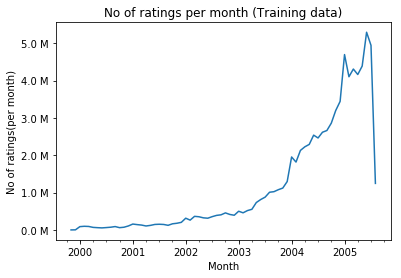

In [22]:
#Number of ratings per month

ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [23]:
#Rated movies count by each user

no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

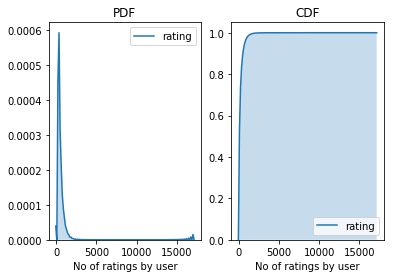

In [24]:
#PDF and CDF on rated movie counts

fig = plt.figure()

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [25]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

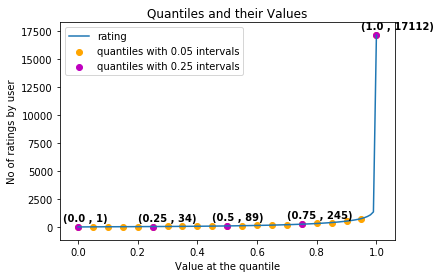

In [27]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [28]:
sum(no_of_rated_movies_per_user>= 749)

20305

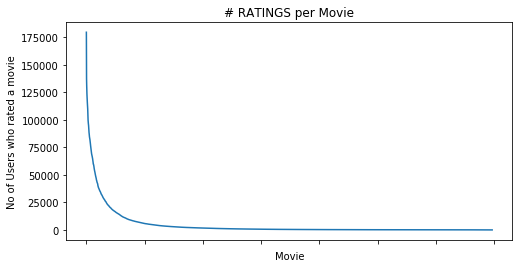

In [29]:
#Ratings of a movie by user

no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

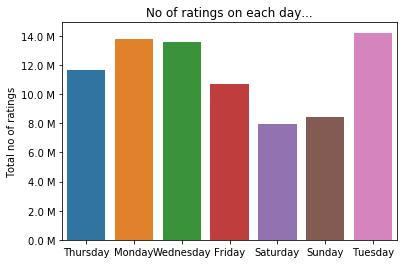

In [30]:
# Number of ratings given each day of week

fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [31]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




In [ ]:
# Creating Sparse matrix
from scipy import sparse

if not os.path(os.path.join(path,'train_sparse_matrix.npz')):
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,train_df.movie.values)))
    sparse.save_npz(os.path.join(path,'train_sparse_matrix.npz'), train_sparse_matrix)  
    
if not os.path(os.path.join(path,'test_sparse_matrix.npz')):
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,test_df.movie.values)))
    sparse.save_npz(os.path.join(path,'test_sparse_matrix.npz'), test_sparse_matrix) 

In [41]:
train_sparse_matrix = sparse.load_npz(os.path.join(path,'train_sparse_matrix.npz'))
test_sparse_matrix = sparse.load_npz(os.path.join(path,'test_sparse_matrix.npz'))

In [42]:
train_averages = dict()

In [43]:
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

In [45]:
def get_average_ratings(sparse_matrix, of_users):
    ax = 1 if of_users else 0 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    is_rated = sparse_matrix!=0
    no_of_ratings = is_rated.sum(axis=ax).A1
    u,m = sparse_matrix.shape
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}
    return average_ratings

In [46]:
#Average Rating Per user

train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
train_averages['user'][10]

3.3781094527363185

In [47]:
#Average Rating per movie

train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
train_averages['movie'][15]

3.3038461538461537

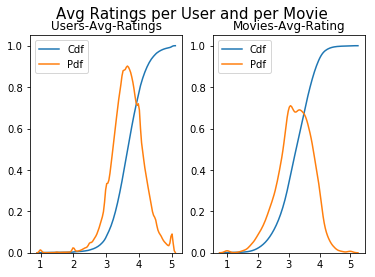

In [48]:
# draw pdfs for average rating per user and average

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()

In [50]:
#Cold Start Problem

total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print(new_users,new_movies)

346 75148


# Data Preparation

In [54]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

In [71]:
if os.path.isfile(os.path.join(path,'sample_train_sparse_matrix.npz')):
    sample_train_sparse_matrix = sparse.load_npz(os.path.join(path,'sample_train_sparse_matrix.npz'))
else:
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=15000, no_movies=500,path = os.path.join(path,'sample_train_sparse_matrix.npz'))

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (15000 500)
Sampled Matrix : Ratings -- 102283
Saving it into disk for furthur usage..
Done..



In [60]:
if os.path.isfile(os.path.join(path,'sample_test_sparse_matrix.npz')):
    sample_test_sparse_matrix = sparse.load_npz(os.path.join(path,'sample_test_sparse_matrix.npz'))
else:
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,path = os.path.join(path,'sample_test_sparse_matrix.npz'))

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..



# Featurization

In [72]:
sample_train_averages = dict()

In [73]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.619154698239199}

In [74]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
sample_train_averages['user'][1515220]

3.75

In [79]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
sample_train_averages['movie'][6415]

3.2222222222222223

In [80]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [81]:
from sklearn.metrics.pairwise import cosine_similarity

if os.path.isfile(os.path.join(path,'reg_train.csv')):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open(os.path.join(path,'reg_train.csv'), mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:]
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings))) 


            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:]
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(sample_train_averages['user'][user])
            row.append(sample_train_averages['movie'][movie])

            row.append(rating)
            count = count + 1

            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Done for {} rows".format(count))

preparing 102283 tuples for the dataset..

Done for 10000 rows
Done for 20000 rows
Done for 30000 rows
Done for 40000 rows
Done for 50000 rows
Done for 60000 rows
Done for 70000 rows
Done for 80000 rows
Done for 90000 rows
Done for 100000 rows


In [82]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [84]:
if os.path.isfile(os.path.join(path,'reg_test.csv')):
    print("It is already created...")
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open(os.path.join(path,'reg_test.csv'), mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            try:       
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] 
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            except (IndexError, KeyError):
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                raise



            try:       
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:]
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise

            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) 
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
                
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
                
            row.append(rating)
            count = count + 1

            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows".format(count)) 

preparing 7333 tuples for the dataset..

Done for 1000 rows
Done for 2000 rows
Done for 3000 rows
Done for 4000 rows
Done for 5000 rows
Done for 6000 rows
Done for 7000 rows


Average rating of all the ratings  
sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )  
smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )  
User's Average rating  
Average rating of this movie  
Rating of this movie by this user

In [3]:
reg_train = pd.read_csv(os.path.join(path,'reg_train.csv'), names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,39297,33,3.619155,1.0,5.0,4.0,4.0,3.0,5.0,5.0,1.000000,5.000000,5.000000,3.203125,4.143646,5
1,53406,33,3.619155,4.0,5.0,3.0,3.0,5.0,2.0,5.0,1.000000,3.000000,4.000000,3.343750,4.143646,4
2,67390,33,3.619155,5.0,5.0,5.0,5.0,1.0,4.0,3.0,2.000000,5.000000,3.000000,3.625000,4.143646,4
3,99540,33,3.619155,1.0,5.0,4.0,5.0,5.0,3.0,4.0,3.333333,3.333333,3.333333,3.333333,4.143646,3
4,99865,33,3.619155,5.0,4.0,5.0,4.0,3.0,4.0,5.0,4.000000,3.000000,5.000000,3.810811,4.143646,5


In [4]:
reg_test = pd.read_csv(os.path.join(path,'reg_test.csv'), names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_test.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,5
1,941866,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,4
2,1737912,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3
3,1849204,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,4
4,28572,111,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,1


In [5]:
# Using Surprise package and hence data is transformed to its format

from surprise import Reader, Dataset

reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset() 

testset = list(zip(reg_test.user.values, reg_test.movie.values, reg_test.rating.values))

In [6]:
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

# Machine Learning Models

In [7]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    
    train_results = dict()
    test_results = dict()
    
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    
    y_train_pred = algo.predict(x_train)    
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)  
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)    
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    
    return train_results, test_results

In [8]:


my_seed = 15
np.random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    return actual, pred

def get_errors(predictions, print_them=False):
    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)
    return rmse, mape*100

def run_surprise(algo, trainset, testset, verbose=True): 
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
        
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
        
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    return train, test

In [9]:
models_evaluation_train = dict()
models_evaluation_test = dict()

# XGBoost with initial 13 features 

In [10]:
import xgboost as xgb

n_estimators = [50,100,1000,2000]

for n_estimator in n_estimators:
    first_xgb = xgb.XGBRegressor(learning_rate =0.1,n_estimators=n_estimator,max_depth=3,min_child_weight=3,gamma=0,subsample=0.8,reg_alpha=200, reg_lambda=200,colsample_bytree=0.8,nthread=4)
    train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)


TEST DATA
------------------------------
RMSE :  1.072757404194858
MAPE :  35.09010095965663

TEST DATA
------------------------------
RMSE :  1.072718051050118
MAPE :  35.07678697437496

TEST DATA
------------------------------
RMSE :  1.0735565643831317
MAPE :  34.72279229046642

TEST DATA
------------------------------
RMSE :  1.0738114836663306
MAPE :  34.68511770630897


[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

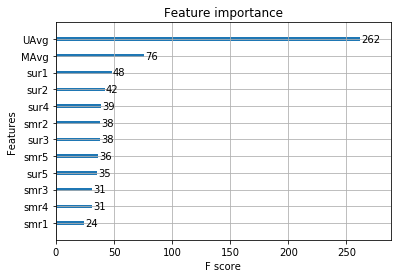

In [11]:
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

# Surprise Baseline Model

In [13]:
from surprise import BaselineOnly 

bsl_options = {'method': 'sgd','learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Estimating biases using sgd...
---------------
Train Data
---------------
RMSE : 0.9408643608703676

MAPE : 29.273759538748216

---------------
Test Data
---------------
RMSE : 1.0735808085059688

MAPE : 35.3095635355278



# XGBoost with initial 13 features + Surprise Baseline predictor

In [14]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_test['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

In [15]:
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,39297,33,3.619155,1.0,5.0,4.0,4.0,3.0,5.0,5.0,1.000000,5.000000,5.000000,3.203125,4.143646,5,3.864574
1,53406,33,3.619155,4.0,5.0,3.0,3.0,5.0,2.0,5.0,1.000000,3.000000,4.000000,3.343750,4.143646,4,2.941372
2,67390,33,3.619155,5.0,5.0,5.0,5.0,1.0,4.0,3.0,2.000000,5.000000,3.000000,3.625000,4.143646,4,3.517910
3,99540,33,3.619155,1.0,5.0,4.0,5.0,5.0,3.0,4.0,3.333333,3.333333,3.333333,3.333333,4.143646,3,3.013273
4,99865,33,3.619155,5.0,4.0,5.0,4.0,3.0,4.0,5.0,4.000000,3.000000,5.000000,3.810811,4.143646,5,3.252006


In [16]:
reg_test.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,5,3.619155
1,941866,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,4,3.619155
2,1737912,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3,3.619155
3,1849204,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,4,3.619155
4,28572,111,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,1,3.619155


In [17]:
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

In [18]:
import xgboost as xgb

n_estimators = [20,50,100,1000,2000]

for n_estimator in n_estimators:
    first_xgb = xgb.XGBRegressor(learning_rate =0.1,n_estimators=n_estimator,max_depth=3,min_child_weight=3,gamma=0,subsample=0.8,reg_alpha=200, reg_lambda=200,colsample_bytree=0.8,nthread=4)
    train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)


TEST DATA
------------------------------
RMSE :  1.1143108988438992
MAPE :  32.9409390025488

TEST DATA
------------------------------
RMSE :  1.073041624550428
MAPE :  35.20670746520377

TEST DATA
------------------------------
RMSE :  1.073282634978916
MAPE :  35.28765506297655

TEST DATA
------------------------------
RMSE :  1.072692625602201
MAPE :  35.10084874148022

TEST DATA
------------------------------
RMSE :  1.0729047895586483
MAPE :  34.899748673173065


[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

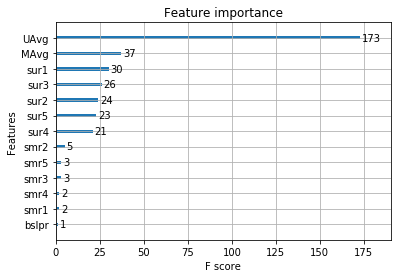

In [19]:
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=50)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)


models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

# Surprise KNN predictors

In [20]:
#KNN predictor with user-user similarity

from surprise import KNNBaseline
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 

bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------
Train Data
---------------
RMSE : 0.26375340495634786

MAPE : 6.9632163770414675

---------------
Test Data
---------------
RMSE : 1.0729740633728826

MAPE : 35.271254738836554



In [22]:
#KNN predictor with movie-movie similarity

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 

bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)


models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------
Train Data
---------------
RMSE : 0.20738563427680795

MAPE : 4.909910774935078

---------------
Test Data
---------------
RMSE : 1.0729630032608906

MAPE : 35.27015318720245



# XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor(movie-movie and user-user)

In [23]:
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_test['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

In [24]:
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

In [25]:
import xgboost as xgb

n_estimators = [20,50,100,1000,2000]

for n_estimator in n_estimators:
    first_xgb = xgb.XGBRegressor(learning_rate =0.1,n_estimators=n_estimator,max_depth=3,min_child_weight=3,gamma=0,subsample=0.8,reg_alpha=200, reg_lambda=200,colsample_bytree=0.8,nthread=4)
    train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)


TEST DATA
------------------------------
RMSE :  1.110061199089461
MAPE :  33.061536460297994

TEST DATA
------------------------------
RMSE :  1.0748175892731193
MAPE :  35.48431087490688

TEST DATA
------------------------------
RMSE :  1.0744953454900543
MAPE :  35.45352137827365

TEST DATA
------------------------------
RMSE :  1.0734559397859733
MAPE :  35.30364435566269

TEST DATA
------------------------------
RMSE :  1.0732112524206407
MAPE :  35.24276011699688



TEST DATA
------------------------------
RMSE :  1.086218472877775
MAPE :  33.90431524927038


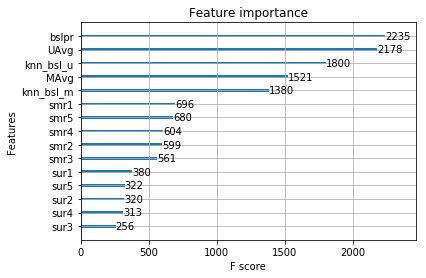

In [26]:
xgb_knn_bsl = xgb.XGBRegressor(n_estimators = 2000,n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

xgb.plot_importance(xgb_knn_bsl)
plt.show()

# SVD

In [27]:
from surprise import SVD

svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
---------------
Train Data
---------------
RMSE : 0.6486886147912374

MAPE : 19.22275390012745

---------------
Test Data
---------------
RMSE : 1.0730035598473069

MAPE : 35.275371586812504



# SVD with Implicit feedback

In [29]:
from surprise import SVDpp

svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
---------------
Train Data
---------------
RMSE : 0.5795854676897524

MAPE : 16.65232190150289

---------------
Test Data
---------------
RMSE : 1.0730045699350494

MAPE : 35.27372737238003



# XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

In [30]:
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_test['svd'] = models_evaluation_test['svd']['predictions']
reg_test['svdpp'] = models_evaluation_test['svdpp']['predictions']

In [31]:
reg_train.head() 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,39297,33,3.619155,1.0,5.0,4.0,4.0,3.0,5.0,5.0,...,5.000000,5.000000,3.203125,4.143646,5,3.864574,4.438328,4.757658,4.257899,4.443822
1,53406,33,3.619155,4.0,5.0,3.0,3.0,5.0,2.0,5.0,...,3.000000,4.000000,3.343750,4.143646,4,2.941372,2.763901,3.033755,2.886369,2.753419
2,67390,33,3.619155,5.0,5.0,5.0,5.0,1.0,4.0,3.0,...,5.000000,3.000000,3.625000,4.143646,4,3.517910,3.159432,3.207347,3.410544,2.966239
3,99540,33,3.619155,1.0,5.0,4.0,5.0,5.0,3.0,4.0,...,3.333333,3.333333,3.333333,4.143646,3,3.013273,2.143493,2.189286,2.606154,2.002570
4,99865,33,3.619155,5.0,4.0,5.0,4.0,3.0,4.0,5.0,...,3.000000,5.000000,3.810811,4.143646,5,3.252006,4.094470,4.657850,4.082666,4.446691


In [32]:
reg_test.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,...,3.619155,3.619155,3.619155,3.619155,5,3.619155,3.619155,3.619155,3.619155,3.619155
1,941866,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,...,3.619155,3.619155,3.619155,3.619155,4,3.619155,3.619155,3.619155,3.619155,3.619155
2,1737912,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,...,3.619155,3.619155,3.619155,3.619155,3,3.619155,3.619155,3.619155,3.619155,3.619155
3,1849204,71,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,...,3.619155,3.619155,3.619155,3.619155,4,3.619155,3.619155,3.619155,3.619155,3.619155
4,28572,111,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,3.619155,...,3.619155,3.619155,3.619155,3.619155,1,3.619155,3.619155,3.619155,3.619155,3.619155


In [34]:
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

x_test = reg_test.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test['rating']

In [35]:
n_estimators = [50,100,200,1000,2000]

for n_estimator in n_estimators:
    first_xgb = xgb.XGBRegressor(learning_rate =0.1,n_estimators=n_estimator,max_depth=3,min_child_weight=3,gamma=0,subsample=0.8,reg_alpha=200, reg_lambda=200,colsample_bytree=0.8,nthread=4)
    train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)


TEST DATA
------------------------------
RMSE :  1.0729387951198937
MAPE :  35.1341386174954

TEST DATA
------------------------------
RMSE :  1.0728143297933976
MAPE :  35.09307085402939

TEST DATA
------------------------------
RMSE :  1.0727342017274528
MAPE :  35.096290699812144

TEST DATA
------------------------------
RMSE :  1.072803584325399
MAPE :  34.972605465043586

TEST DATA
------------------------------
RMSE :  1.0729661833083801
MAPE :  34.90097416244348



TEST DATA
------------------------------
RMSE :  1.0734467307804618
MAPE :  35.30939105559633


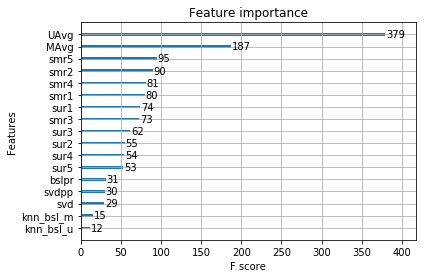

In [36]:
xgb_final = xgb.XGBRegressor(n_estimators = 200,n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

xgb.plot_importance(xgb_final)
plt.show()

# XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

In [37]:
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

x_test = reg_test[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test['rating']

In [38]:
n_estimators = [50,100,200,1000,2000]

for n_estimator in n_estimators:
    first_xgb = xgb.XGBRegressor(learning_rate =0.1,n_estimators=n_estimator,max_depth=3,min_child_weight=3,gamma=0,subsample=0.8,reg_alpha=200, reg_lambda=200,colsample_bytree=0.8,nthread=4)
    train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)


TEST DATA
------------------------------
RMSE :  1.0753486012570554
MAPE :  35.31591118826174

TEST DATA
------------------------------
RMSE :  1.076225656110753
MAPE :  35.518113788656066

TEST DATA
------------------------------
RMSE :  1.07578114716822
MAPE :  35.42905949555699

TEST DATA
------------------------------
RMSE :  1.0754858569018322
MAPE :  35.347175453244475

TEST DATA
------------------------------
RMSE :  1.0754063399639147
MAPE :  35.32436640822155



TEST DATA
------------------------------
RMSE :  1.0752397685718569
MAPE :  35.22371287031376


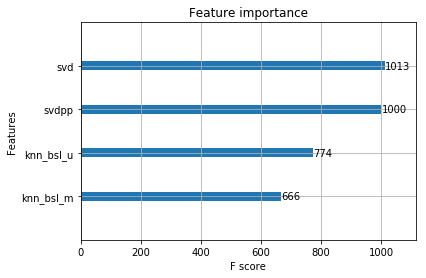

In [40]:
xgb_all_models = xgb.XGBRegressor(n_estimators =500 ,n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

# Conclusion

In [68]:
algos = []
train_rsmes = []
test_rsmes = []

for each_algo in models_evaluation_train:
    algos.append(each_algo)
    check = models_evaluation_train[each_algo]
    train_rsmes.append(check['rmse'])
    
for each_algo in models_evaluation_test:
    check = models_evaluation_test[each_algo]
    test_rsmes.append(check['rmse'])

In [73]:
from prettytable import PrettyTable
    
Table = PrettyTable()

Table.field_names  = ["Model", "Train_rmse", "Test_rmse"]

for i in range(0,10,1):
    Table.add_row([algos[i],train_rsmes[i],test_rsmes[i]])

print(Table)

+----------------+---------------------+--------------------+
|     Model      |      Train_rmse     |     Test_rmse      |
+----------------+---------------------+--------------------+
|   first_algo   |  0.8131655657201271 | 1.0736360638377618 |
|    bsl_algo    |  0.9408643608703676 | 1.0735808085059688 |
|    xgb_bsl     |  0.8206049195071748 | 1.073068397290458  |
|   knn_bsl_u    | 0.26375340495634786 | 1.0729740633728826 |
|   knn_bsl_m    | 0.20738563427680795 | 1.0729630032608906 |
|  xgb_knn_bsl   |  0.7634494751495742 | 1.086218472877775  |
|      svd       |  0.6486886147912374 | 1.0730035598473069 |
|     svdpp      |  0.5795854676897524 | 1.0730045699350494 |
|   xgb_final    |  0.8068454624363004 | 1.0734467307804618 |
| xgb_all_models |  1.0606454093218731 | 1.0752397685718569 |
+----------------+---------------------+--------------------+
